# 매개변수 갱신

+ 경사하강법은 단점이 존재함
+ 다른 최적화 방법을 구현하고 모듈화

In [1]:
class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []
    
    # 업데이트 할 모델 설정
    def setup(self, target):
        self.target = target
        return self
    
    # 모든 파라미터에 대해 업데이트 수행
    def update(self):
        # grad가 계산된 파라미터만 가져온다.
        params = [p for p in self.target.params() if p.grad is not None]
        for f in self.hooks:
            f(params)
            
        for param in params:
            self.update_one(param)
            
    # 이 부분을 상속하여 작성하면 update 함수가 실행 될 때 마다 호출된다.
    def update_one(self, param):
        raise NotImplementedError()
    
    def add_hook(self, f):
        self.hooks.append(f)

여기서 hook의 의미가 뭔지 모르겠다.

->

```python
def print_params(params):
    print("Updating the following parameters:")
    for param in params:
        print(param)

optimizer = Optimizer()
optimizer.add_hook(print_params)
```
처럼 optimizer에 추가할 수 있도록 한거같다.

In [2]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr
        
    # optimizer를 상속하기 때문에 update_one 함수를 구현
    # 일반적인 gradient descent 방법을 사용
    def update_one(self, param):
        param.data -= self.lr * param.grad.data

In [3]:
from dezero import Model
from dezero import optimizers
from dezero import functions as F
from dezero import layers as L

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

In [4]:
import numpy as np

lr = 0.2
max_iter = 10000
hidden_size = 10

x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

model = TwoLayerNet(hidden_size, 1)
optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    # 구현한 옵티마이저 사용
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)

variable(0.946801882909269)
variable(0.2742428775193018)
variable(0.2672723053449282)
variable(0.24438344252510733)
variable(0.1690398421545272)
variable(0.08686591364781072)
variable(0.07724930355954787)
variable(0.0766987975504355)
variable(0.07788383844533366)
variable(0.07624527582946533)


In [5]:
# dezero 패키지에 있는 optimizers 모듈을 사용하여 최적화를 수행
from dezero import optimizers

lr = 0.2
max_iter = 10000
hidden_size = 10

x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

model = TwoLayerNet(hidden_size, 1)
optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    # 구현한 옵티마이저 사용
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)

variable(1.3933853654077597)
variable(0.25318816813378137)
variable(0.2095911587057899)
variable(0.11527710911302595)
variable(0.0812104018721248)
variable(0.07941587288608112)
variable(0.07902979381430898)
variable(0.07873629217110208)
variable(0.07849353362964863)
variable(0.0784249635580505)


SGD 이외의 옵티마이저
+ momentum
+ adagrad
+ adadelta
+ adam

In [6]:
import dezero.cuda as cuda

class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}
    
    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            xp = cuda.get_array_module(param.data)
            self.vs[v_key] = np.zeros_like(param.data)
            
        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

나머지 옵티마이저도 구현

In [7]:
class AdaGrad(Optimizer):
    def __init__(self, lr=0.001, eps=1e-8):
        super().__init__()
        self.lr = lr
        self.eps = eps
        self.hs = {}

    def update_one(self, param):
        xp = cuda.get_array_module(param.data)

        h_key = id(param)
        if h_key not in self.hs:
            self.hs[h_key] = xp.zeros_like(param.data)

        lr = self.lr
        eps = self.eps
        grad = param.grad.data
        h = self.hs[h_key]

        h += grad * grad
        param.data -= lr * grad / (xp.sqrt(h) + eps)

In [8]:
class AdaDelta(Optimizer):
    def __init__(self, rho=0.95, eps=1e-6):
        super().__init__()
        self.rho = rho
        self.eps = eps
        self.msg = {}
        self.msdx = {}

    def update_one(self, param):
        xp = cuda.get_array_module(param.data)

        key = id(param)
        if key not in self.msg:
            self.msg[key] = xp.zeros_like(param.data)
            self.msdx[key] = xp.zeros_like(param.data)

        msg, msdx = self.msg[key], self.msdx[key]
        rho = self.rho
        eps = self.eps
        grad = param.grad.data

        msg *= rho
        msg += (1 - rho) * grad * grad
        dx = xp.sqrt((msdx + eps) / (msg + eps)) * grad
        msdx *= rho
        msdx += (1 - rho) * dx * dx
        param.data -= dx

In [9]:
import math

class Adam(Optimizer):
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__()
        self.t = 0
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.ms = {}
        self.vs = {}

    def update(self, *args, **kwargs):
        self.t += 1
        super().update(*args, **kwargs)

    @property
    def lr(self):
        fix1 = 1. - math.pow(self.beta1, self.t)
        fix2 = 1. - math.pow(self.beta2, self.t)
        return self.alpha * math.sqrt(fix2) / fix1

    def update_one(self, param):
        xp = cuda.get_array_module(param.data)

        key = id(param)
        if key not in self.ms:
            self.ms[key] = xp.zeros_like(param.data)
            self.vs[key] = xp.zeros_like(param.data)

        m, v = self.ms[key], self.vs[key]
        beta1, beta2, eps = self.beta1, self.beta2, self.eps
        grad = param.grad.data

        m += (1 - beta1) * (grad - m)
        v += (1 - beta2) * (grad * grad - v)
        param.data -= self.lr * m / (xp.sqrt(v) + eps)

# softmax, mse 구현

+ 다중 클래스 분류시 필요한 모듈 구현

## get_item 함수 사용

+ 다차원 배열에서 일부를 가져오는 함수
+ 역전파시 해당 위치를 기억하고 크기를 복원해야함

In [10]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.get_item(x, 1)
print(x)
y.backward()
print(y)
print(x.grad)

variable([[1 2 3]
          [4 5 6]])
variable([4 5 6])
variable([[0 0 0]
          [1 1 1]])


In [11]:
from dezero.models import MLP

model = MLP((10, 3))
print(model)

In [12]:
x = np.array([[0.2, -0.4]])
y = model(x)
print(y)

variable([[0.15096982 0.09799455 0.6511832 ]])


## softmax 함수 구현

In [13]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [14]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

# 합이 1이 되는지 확인
print(sum(p[0]))

variable([[0.15096982 0.09799455 0.6511832 ]])
variable([[0.27797262 0.2636302  0.45839718]])
variable(1.0)


텐서에 맞게 softmax가 적용될 수 있도록 해야한다.

사용자가 축을 선택할 수 있도록 한다.

In [15]:
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = x - F.max(x, axis=axis, keepdims=True)
    y = F.exp(y)
    sum_y = F.sum(y, axis=axis, keepdims=True)
    return y / sum_y

In [16]:
x = Variable(np.array([[0.2, -0.4], [0.3, 0.5], [1.3, 0.1]]))
y = model(x)
p_0 = softmax_simple(y, axis=0)
p_1 = softmax_simple(y, axis=1)
print(y)
# axis=0일 때는 열을 기준으로 계산
print(p_0)
# axis=1일 때는 행을 기준으로 계산
print(p_1)

variable([[ 0.15096982  0.09799455  0.6511832 ]
          [ 0.26533907 -0.01079112  0.87420655]
          [ 0.38755029 -0.19805216  1.23379975]])
variable([[0.29515281 0.37869101 0.24748998]
          [0.3309153  0.33965654 0.3093253 ]
          [0.37393189 0.28165245 0.44318472]])
variable([[0.27797262 0.2636302  0.45839718]
          [0.27800463 0.21092605 0.51106933]
          [0.25722423 0.14321482 0.59956095]])


## cross entropy error 구현

+ 다중 클래스에서 맞는 손실함수를 구현해야한다.

In [17]:
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    
    p = F.softmax(x)
    p = F.clip(p, 1e-15, 1.0)
    log_p = F.log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -F.sum(tlog_p) / N
    return y

In [18]:
x = Variable(np.array([[0.2, -0.4], [0.3, 0.5], [1.3, 0.1]]))
t = Variable(np.array([0, 2, 1]))
y = model(x)
loss = softmax_cross_entropy_simple(y, t)
print(loss)

variable(1.2982974082031558)


# spiral 데이터셋으로 확인하기

In [19]:
import dezero.datasets as ds

x, t = ds.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1


epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

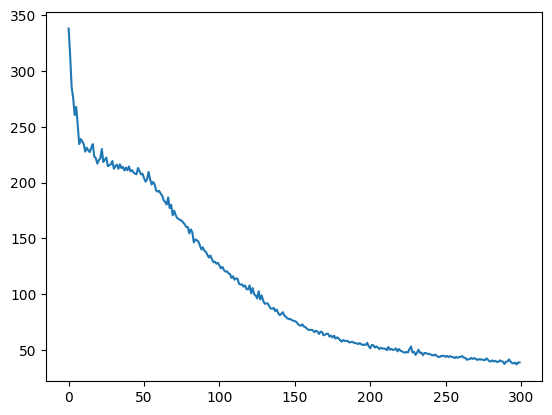

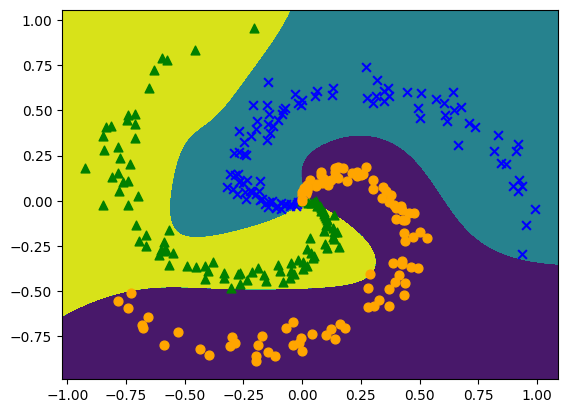

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = ds.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

avg_loss_list = []

for epoch in range(max_epoch):
    index = np.random.permutation(data_size)
    sum_loss = 0
    
    for i in range(max_iter):
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]
        
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(batch_t)
        
    avg_loss = sum_loss / data_size
    avg_loss_list.append(sum_loss)
    print(f'epoch {epoch+1}, loss {avg_loss:.2f}')

plt.plot(avg_loss_list)
plt.show()

h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.no_grad():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

# Plot data points of the dataset
N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40,  marker=markers[c], c=colors[c])
plt.show()

---

# ATTENTION 분석

기존 seq2seq에서 문제점:
+ encoder에서 출력된 값이 decoder에서 lstm층으로 입력될 때, 계산된 출력값이 다음 layer의 입력값으로 들어가고, 또 계산된 출력값이 그 다음 layer의 입력값으로 들어가는 행위가 반복되면서 길어지면서 기울기 소실 문제가 생긴다.
+ encoder에서 출력된 벡터의 크기가 항상 일정하므로 짧은 문장이 들어올 땐 상관없지만, 엄청 긴 문장이 들어올 땐 문장을 압축을 해야하므로 정보의 손실을 발생시킨다.

수정:
+ 인코더에서 마지막 벡터만을 디코더로 보내는것이 아니라 모든 단어의 값을 디코더로 보내도록 변경한다.
+ encoder에서 출력하는 벡터의 크기를 고정하지 않고 입력받은 벡터를 그대로 다시 decoder에 넣도록 한다.

문장 번역을 한다고 했을때.

다음 단어가 뭐가 나와야 가장 적절한가? -> 그 많은 단어 뭉치중에 가장 적절한 단어를 고르는 작업이 필요하다.

가장 중요한 단어를 고르기 위해 가장 중요한 단어를 고르는 방법이 필요하다.

1. 단어에 대한 중요도를 구하기:

    어찌어찌 단어들의 가중치를 계산하여 문장 벡터에 가중치를 계산해서 decoder에 넘겨준다. -> 각 문장에서 중요한 단어들의 벡터값이 높게 설정된다.

2. 가중치 계산하기:

    벡터값을 내적한다. -> 내적을 계산하여 값이 크면 두 벡터가 유사하다고 할 수 있다.

3. 두 과정을 합치는 과정이 attention

    가중치를 계산하는 attention weight layer, 중요도를 구하는 weight sum layer

모든 attention layer에서 모든 문장 벡터를 사용하기 때문에 기울기 소실 문제가 생기지 않는다.

입력 벡터값을 문장과 동일한 크기의 벡터값이므로 크기에 영향을 받지 않는다.

Attention에서 핵심은..

가중치와 가중치 곱을 하는 과정